This is an introductory description of Text Data Analytics using Support Tickets Data. The data is taken from this case study done by Microsoft & Endava hosted at https://github.com/karolzak/support-tickets-classification. 

The github repository contains nice python code to build an Naive Bayes & SVM models to predict multiple categorical labels for the tickets. They also used GridSearchCV to search for the optimal hyper parameters for these models. The code presented is quite well commented but can be daunting to understand for a beginner. 

Here i try to break up that code bit by bit to understand the transformations performed by every function. Interestingly all imports will be done just before they are needed, so that it is clear what package is adding what bits in the overall analysis. So Lets begin:

In [2]:
#Load Data
import pandas as pd
tkts = pd.read_csv("all_tickets.csv")
print(tkts.shape)
tkts.head()

(48549, 9)


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


The dataset contains 48549 support tickets raised by users. The interesting column here is "body", which contains the "text of Subject" + "text of email body" written by user. Also worth noting is that the dataset has been very effectively cleaned in a different script in repo, which saves us a lot of hassles.
In NLP terms each of the body elements is a document and the casestudy built various document classification models on top of it. In default settings the column "ticket_type" is predicted using Naive Bayes algorithm. 

In [3]:
tkts['body_len'] = tkts['body'].str.len()
tkts['body_len'].describe()

count    48549.000000
mean       266.640178
std        384.651236
min          2.000000
25%         88.000000
50%        150.000000
75%        275.000000
max       7011.000000
Name: body_len, dtype: float64

So the text data field is as small as 2 characters & as large as 7011 characters. Mean length is 266.6. Let us see the size of vocabulary by counting number of unique words. 

In [4]:
unqwords = set()
tkts['body'].str.split().apply(unqwords.update)
print('Count:', len(unqwords))

Count: 12259


So One Hot Encoding Feature representation for the dataset would be a matrix of 12259 X 48549 size. 
607 Million binary values amounting to a size of 607Mb. The size here might not be intimidating since sample 
size is quite small for a NLP problem. Also this model will not work if any new word is present in the 
unseen test data.

In the first exercise, let us try to predict ticket_type field for a ticket. Let us see what valuee this 
column contain, along with its distribution. 

In [6]:
tkts.ticket_type.value_counts()

1    34621
0    13928
Name: ticket_type, dtype: int64

ticket_type is a categorical variable with 2 values (0 & 1). 
The class distribution is not ideal, but neither too extreme. In case class distribution is too skewed, we can
consider passing in the minority class data multiple times, to balance the skewness. Let us move forward towards building a model. 
The biggest challenge in building a machine learning model (or statistical model) for NLP data is its unstructured format. The solution is to convert the unstructured text document into structured format by computing some of its properties. 

Simplest properties can be to compute lenght of the document in chars (or words / lines etc). In case the task was to classify wheather a document is a novel or a news article, even such a simple feature might be enough. Here let us just try to see the correlation of ticket_type of length of document as a fun exercise. 

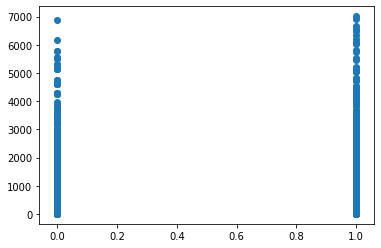

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(tkts.ticket_type, tkts.body_len)


In [10]:
tkts[['ticket_type', 'body_len']].corr()

,ticket_type,body_len
ticket_type,1.000000,-0.112221
body_len,-0.112221,1.000000


As seen in the scatterplot and correlation matrix, there is no significant correlation between between ticket_type and body_len. Let us move towards a more formal approach. 

Now coming to formal methods as introduced in NLP classes, we can create a vocabulary of most frequent words, say 1000 most frequent words. Then we can create a 1000 length feature vector, where every feature is 0 or 1 depending on if the particular word is present in the document of not. A variant of method 3 can store the number of times the word occurred in a document. 

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv_docs = cv.fit_transform(tkts['body'])
cv_docs.shape

(48549, 12258)

As explained earlier, we have a 48549 documents X 12258 unique words matrix of tf-idf scores for our document 
corpus. Let us build a Multinomial Naive Bayes Classifier now:

In [22]:
label_data = tkts['ticket_type']
data = cv_docs

from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data, label_data, test_size=0.2)

print(train_data.shape)
print(test_data.shape)

(38839, 12258)
(9710, 12258)


In [23]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
mnb = MultinomialNB()
mnb.fit(train_data, train_label)

pred_label = mnb.predict(test_data)
prediction_acc = np.mean(pred_label == test_label)
print('Model Accuracy:' + str(prediction_acc))

Model Accuracy:0.9926879505664263


Concept of TF-IDF: In NLP Classification problems, it is seen that certain words are very good indicators of a document class. Say if the word "inflation" appears multiple times in a document, it is quite certain that the document is from a economics journal. This property of counting the number of occurrences of a given word is called Terf Frequency (TF). However there is another category of words which are very common - fillers. These are words like "the", "of", "from" etc, which are very common in any english text. Since these words add little information in classification, Inverse Document Frequency is computed to reduce the weights of these terms. IDF basically computes inverse of number of documents in which a word is present. Generally it is computed as a logarithm of ratio of total documents and number of documents containing the term. 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(use_idf=True)
tfidf_vec_docs = tfidf_vec.fit_transform(tkts['body'])
tfidf_vec_docs.shape

label_data = tkts['ticket_type']
data = tfidf_vec_docs

from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data, label_data, test_size=0.2)

print(train_data.shape)
print(test_data.shape)

(38839, 12258)
(9710, 12258)


In [27]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
mnb = MultinomialNB()
mnb.fit(train_data, train_label)

pred_label = mnb.predict(test_data)
prediction_acc = np.mean(pred_label == test_label)
print('Model Accuracy:' + str(prediction_acc))

#Compute F Score
from sklearn.metrics import f1_score
f_score = f1_score(test_label, pred_label)
print("Model F-Score:" + str(f_score))

Model Accuracy:0.9942327497425335
Model F-Score:0.9959213401310998


In [ ]:
Well both Count Based and TFIDF based models give similar accuracy numbers of ~99.3%. Since Class distributions are fairly balanced F-Score is also quire 